In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import numpy as np
import boto3
import cv2

fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
images = fs.ls('s3://sxm-ecommerce-p66-location-data/images/roadmap_marked/')

In [2]:
client = boto3.client('s3')
path = 's3://sxm-ecommerce-p66-location-data/coords/100_coords.csv'
df = pd.read_csv(path)
df.drop('location_id', axis=1, inplace=True)
df.drop('merchant_location_id', axis=1, inplace=True)
df.sort_values(by=['merchant_location_latitude'], inplace=True)
df.head()

,merchant_location_latitude,merchant_location_longitude
58,21.331533,-157.865814
47,28.782888,-97.045563
80,29.449435,-95.078111
59,29.617713,-95.564214
94,30.166849,-81.748018


In [3]:

freq_imgs = fs.ls('s3://sxm-ecommerce-p66-location-data/freqs')
freq_imgs.pop(0)


freq_imgs = [str(freq).replace( 'sxm-ecommerce-p66-location-data/freqs/img_', '') for freq in freq_imgs]
freq_imgs = [str(freq).replace( '.png', '') for freq in freq_imgs]


road_or_not = {'location': freq_imgs, 'type': [0] * len(freq_imgs)}
road_or_not_df = pd.DataFrame(road_or_not) 
road_or_not_df.to_csv('data/freqs/road_or_building.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


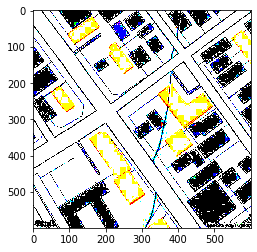

0


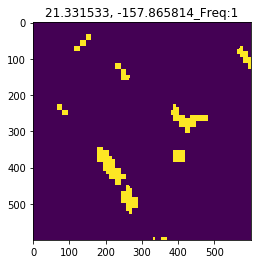

1


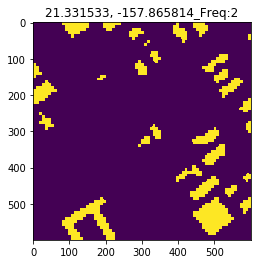

2


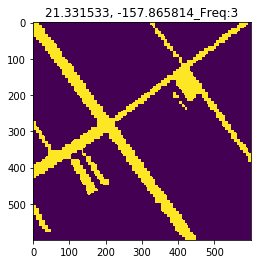

3


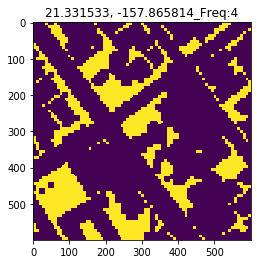

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


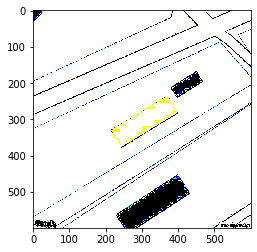

0


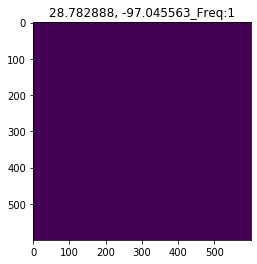

1


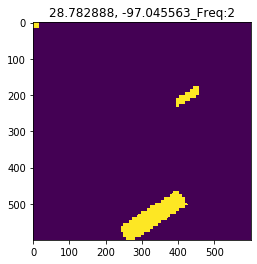

2


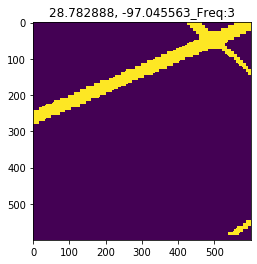

3


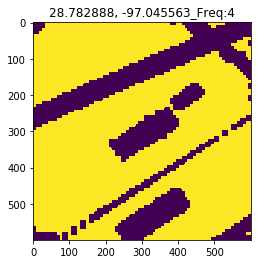

In [5]:
img_num = 0
for image in images[:2]:
    with fs.open(image) as f:
        i = plt.imread(f, 0)
        #print(i.shape)
        #print(image)
        plt.imshow(i)
        #plt.show()
        flatImage = np.reshape(i, (i.shape[0]*i.shape[1], i.shape[2]))
        
        uniqueColor, counts = np.unique(flatImage, axis=0, return_counts=True)
        #print(np.min(uniqueColor), np.max(uniqueColor))
        # print(counts.shape)
        sortedCounts = np.sort(counts)
        argSortedCounts = np.argsort(counts)
        # print(sortedCounts[-10:], argSortedCounts[-10:])
        # print(np.sum(sortedCounts))
        # print(uniqueColor.shape)
        
        kernelC = np.ones((10, 10), np.uint8)
        kernelO = np.ones((5, 5), np.uint8)
        
        numColors = 4
        maxColor = np.zeros(3)
        minColor = np.array([255, 255, 255])
        for color_idx in argSortedCounts[-numColors:]:
            color = uniqueColor[color_idx]
            R = color[0]
            G = color[1]
            B = color[2]
            if R > maxColor[0]:
                maxColor[0] = R
            if G > maxColor[1]:
                maxColor[1] = G
            if B > maxColor[2]:
                maxColor[2] = B
                
            if R < minColor[0]:
                minColor[0] = R
            if G < minColor[1]:
                minColor[1] = G
            if B < minColor[2]:
                minColor[2] = B
       # print(maxColor)
       # print(minColor)
       # print(i.shape)
        iContrast = np.zeros(i.shape)
        #print(iContrast.shape)
        #print(minColor.shape)
        #print(maxColor.shape)
        iContrast = (i - minColor) * 255 / (maxColor - minColor)
#         print(i.shape)
        plt.imshow(iContrast)
        plt.show()
#         print(i[:, :, 0] - minColor[0] * 255/(maxColor[0]-minColor[0]))
#         i[:, :, 1] = i[:, :, 1]-minColor[0] * 255/(maxColor[1]-minColor[1])
#         i[:, :, 2] = i[:, :, 2]-minColor[2] * 255/(maxColor[2]-minColor[2])
        
#         plt.imshow(i)
#         plt.show()
#         color = color-mincolor * 255/(maxcolor-mincolor) FORMULA
        
        num = 0
        for color_idx in argSortedCounts[-numColors:]:
            print(num)
            num += 1
            color = uniqueColor[color_idx]
            #print(color)
            
            colorImage = i == color
#             print(colorImage.shape)
            stacked = np.sum(colorImage, axis=2)
            stacked = stacked >= 3
            stacked = np.asarray(stacked, dtype=float)
            opened = cv2.morphologyEx(stacked, cv2.MORPH_OPEN, kernelO)
            closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernelC)
        
            # np.savetxt('stacked.txt', stacked, fmt='%.1e')
#             with open('../data/detection/%d.png' % (color_idx), 'wb') as file:
#                 file.write(stacked)

            lat_coords = df['merchant_location_latitude'].values[img_num]
            long_coords = df['merchant_location_longitude'].values[img_num]
            plt.imshow(closed)
            plt.title('%f, %f_Freq:%i' % (lat_coords, long_coords, num))
            plt.savefig('data/freqs/imgs/img_%f, %f_freq_%i.png' % (lat_coords, long_coords, num), bbox_inches='tight')
            plt.show()
#             plt.imshow(opened)
#             plt.show()
#             plt.imshow(closed)
#             plt.show()
    img_num +=1